# Jewellery Recommendation System

In [1]:
import os
import re
import pandas as pd

from PIL import Image
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

%matplotlib inline

## 1. Dataset Path

In [2]:
data_dir = "C:\\jewellery"

## 2. Load CSV Metadata (if exists)

In [3]:
csv_file = os.path.join(data_dir, "metadata.csv")

if os.path.exists(csv_file):
    df = pd.read_csv(csv_file)
    print("CSV Preview:")
    print(df.head())
else:
    raise FileNotFoundError("metadata.csv not found. This system requires metadata.")


CSV Preview:
                                        Product Name  \
0  Heart n Arrow Noble Royal Brilliance ring 18K ...   
1  Heart n Arrow Noble Royal Brilliance ring 18K ...   
2  Heart n Arrow Noble Royal Brilliance ring 18K ...   
3  Heart n Arrow Noble Royal Brilliance ring 18K ...   
4  Heart n Arrow Noble Royal Brilliance ring 18K ...   

                                           file_name  \
0  heart-n-arrow-noble-royal-brilliance-ring-18k-...   
1  heart-n-arrow-noble-royal-brilliance-ring-18k-...   
2  heart-n-arrow-noble-royal-brilliance-ring-18k-...   
3  heart-n-arrow-noble-royal-brilliance-ring-18k-...   
4  heart-n-arrow-noble-royal-brilliance-ring-18k-...   

                                         Description  Article Id  Price  \
0   "Enhance your elegance with the exquisite Nob...  RVNC47JLBB  43600   
1   "Enhance your elegance with the exquisite Nob...  RVNC47JLBB  43600   
2   "Enhance your elegance with the exquisite Nob...  RVNC47JLBB  43600   
3   "Enhance 

## 3. Load image file paths

In [4]:
img_files = []

for root, dirs, files in os.walk(data_dir):
    for f in files:
        if f.lower().endswith((".jpg", ".png")):
            img_files.append(os.path.join(root, f))

print(f"Total images found: {len(img_files)}")
print("First 5 image paths:", img_files[:5])


Total images found: 6641
First 5 image paths: ['C:\\jewellery\\1.png', 'C:\\jewellery\\55carat-natural-14-mukhi-fourteen-faced-nepali-rudraksh-beads-at-wholesale-rate-loose-seed-fine-quality-for-spiritual-healing-1pcs-product-images-rv2z80gywl-0-202306091420.jpg', 'C:\\jewellery\\55carat-natural-14-mukhi-fourteen-faced-nepali-rudraksh-beads-at-wholesale-rate-loose-seed-fine-quality-for-spiritual-healing-1pcs-product-images-rv2z80gywl-1-202306091420.jpg', 'C:\\jewellery\\55carat-natural-14-mukhi-fourteen-faced-nepali-rudraksh-beads-at-wholesale-rate-loose-seed-fine-quality-for-spiritual-healing-1pcs-product-images-rv2z80gywl-2-202306091420.jpg', 'C:\\jewellery\\55carat-natural-14-mukhi-fourteen-faced-nepali-rudraksh-beads-at-wholesale-rate-loose-seed-fine-quality-for-spiritual-healing-1pcs-product-images-rv2z80gywl-3-202306091420.jpg']


## 4. Display one sample image

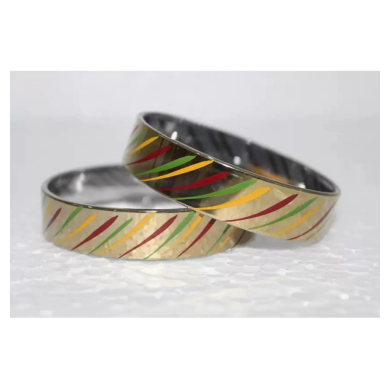

In [5]:
if img_files:
    img = Image.open(img_files[5])
    plt.imshow(img)
    plt.axis("off")
    plt.show()
else:
    print("No images found.")


## 5 DATA CLEANING & VALIDATION
Clean missing values



In [6]:
df.fillna("", inplace=True)



# 1. Remove duplicate products
df.drop_duplicates(subset="Article Id", inplace=True)

# 2. Convert Price to numeric safely
df["Price"] = pd.to_numeric(df["Price"], errors="coerce")

# 3. Remove rows with missing or invalid prices
df = df[df["Price"].notna()]
df = df[df["Price"] > 0]

# 4. Fill missing text fields (safe for TF-IDF)
text_columns = [
    "Product Name",
    "Description",
    "Features",
    "Product Type",
    "Brand",
    "Country of Origin"
]

for col in text_columns:
    df[col] = df[col].fillna("")

# 5. Normalize text (lowercase + strip spaces)=
for col in text_columns:
    df[col] = df[col].str.lower().str.strip()

print(f"Cleaned dataset size: {len(df)} products")


Cleaned dataset size: 1926 products


## 6. Feature Engineering

In [7]:
# Combine meaningful text columns

df["combined_features"] = (
    df["Product Name"] + " " +
    df["Description"] + " " +
    df["Features"] + " " +
    df["Product Type"] + " " +
    df["Brand"] + " " +
    df["Country of Origin"]
)


## 7. Convert text to vectors
(Content-Based Filtering)

In [19]:
vectorizer = TfidfVectorizer(stop_words="english")
feature_vectors = vectorizer.fit_transform(df["combined_features"])
feature_vectors.shape

(1926, 5214)

## 8. Take ONE user input only

In [9]:
user_query = input(
    "Enter jewellery preference (example: gold necklace under 50000): "
).lower()

Enter jewellery preference (example: gold necklace under 50000):  anklet under 200


# 9. Extract optional price
Supports: under / below / upto

In [10]:
price_match = re.search(
    r'under\s*(\d+)|below\s*(\d+)|upto\s*(\d+)',
    user_query
)

max_budget = None
if price_match:
    max_budget = int(next(p for p in price_match.groups() if p))


## 10. Remove price text from query
(So it doesn't affect similarity)

In [11]:
clean_query = re.sub(
    r'under\s*\d+|below\s*\d+|upto\s*\d+',
    '',
    user_query
)


## 11. Vectorize user query

In [20]:

user_vector = vectorizer.transform([clean_query])
similarity_scores = cosine_similarity(user_vector, feature_vectors)
similarity_scores

array([[0., 0., 0., ..., 0., 0., 0.]])

In [21]:
df["similarity"] = similarity_scores[0]
df[["Product Name", "similarity"]].head()

,Product Name,similarity
0,heart n arrow noble royal brilliance ring 18k ...,0.0
5,heart n arrow noble adrian's splendour ring 18...,0.0
9,55carat natural 14 mukhi fourteen faced nepali...,0.0
13,rajasthan gems bracelet 925 sterling silver je...,0.0
16,rajasthan gems kada men bracelet bangle silver...,0.0


## 12. Apply price filter ONLY if given

In [13]:
if max_budget:
    filtered_df = df[df["Price"] <= max_budget]
else:
    filtered_df = df.copy()



## 13. Get top recommendations

In [14]:
top_n = 5

recommendations = (
    filtered_df
    .sort_values(by="similarity", ascending=False)
    .head(top_n)
)


## 14. Display recommendation table

In [23]:
from IPython.display import display

display(
    recommendations[
        [
            "Article Id",
            "Product Name",
            "Price",
            "Brand",
            "Product Type",
            "Product Url",
            "similarity"
        ]
    ]
)

,Article Id,Product Name,Price,Brand,Product Type,Product Url,similarity
6604,RVO8BKOKT7,br ornaments alloy anklet (pack of 2),199,br ornaments,anklet,https://www.jiomart.com//p/groceries/br-orname...,0.503903
6412,RV575GUFIR,br ornaments latest trends black beaded anklet...,199,br ornaments,anklet,https://www.jiomart.com//p/groceries/br-orname...,0.462526
6599,RVMHIASN6B,br ornaments allure charming women anklets & t...,199,br ornaments,anklet,https://www.jiomart.com//p/groceries/br-orname...,0.450999
6608,RVTWWDB8NP,br ornaments allure charming women anklets & t...,199,br ornaments,anklet,https://www.jiomart.com//p/groceries/br-orname...,0.450999
6574,RVGFYBGNRA,br ornaments allure glittering women anklets &...,199,br ornaments,anklet,https://www.jiomart.com//p/groceries/br-orname...,0.448675


## 15. Display product images

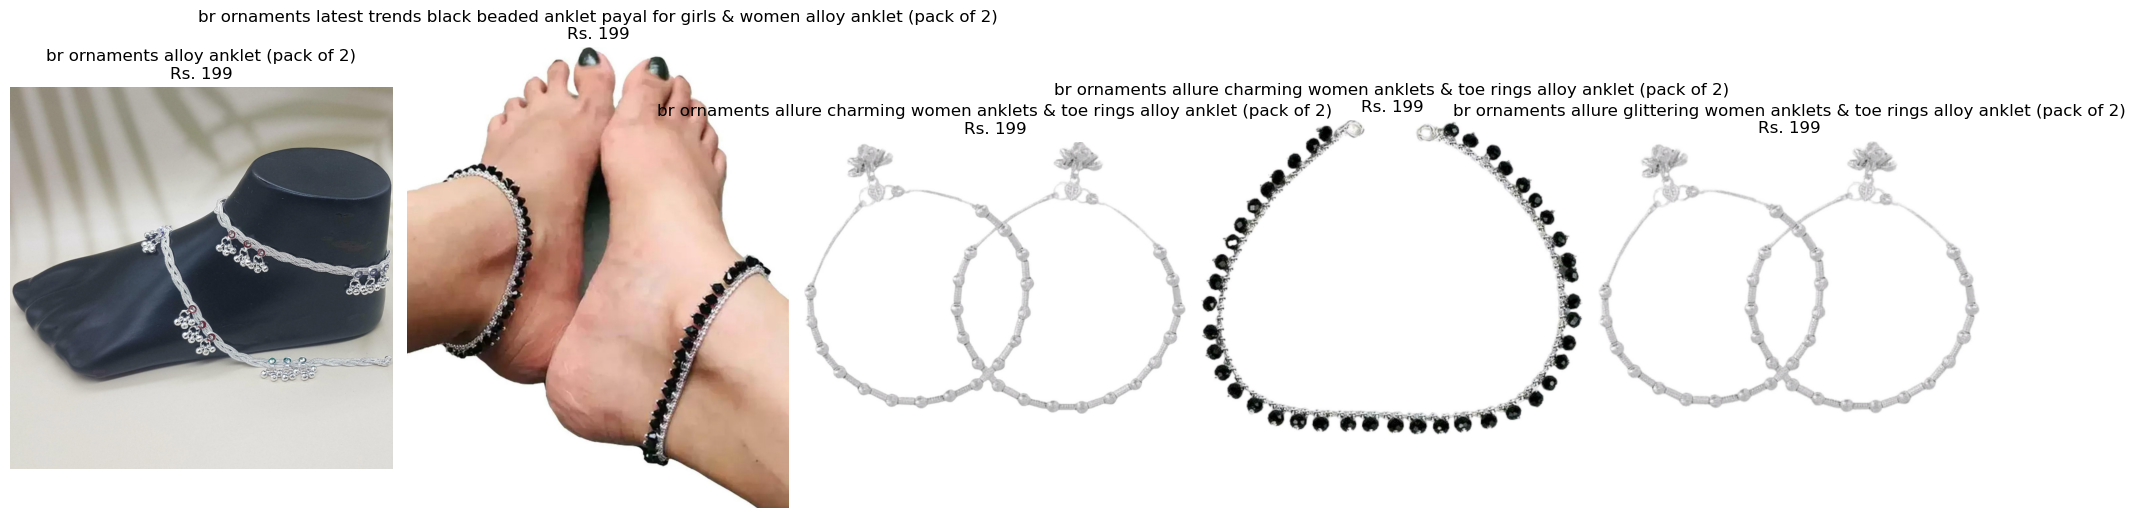

In [24]:
import math

n = len(recommendations)
cols = n
rows = 1

plt.figure(figsize=(4 * cols, 5))

for i, (_, row) in enumerate(recommendations.iterrows()):
    img_path = os.path.join(data_dir, row["file_name"])

    if os.path.exists(img_path):
        img = Image.open(img_path)
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.title(f"{row['Product Name']}\nRs. {row['Price']}")
        plt.axis("off")

plt.tight_layout()
plt.show()


In [17]:
# # ================================

# # Jewellery Recommendation System

# # One input | Optional price

# # ================================



# import os

# import re

# import pandas as pd



# from PIL import Image

# import matplotlib.pyplot as plt

# from sklearn.feature_extraction.text import TfidfVectorizer

# from sklearn.metrics.pairwise import cosine_similarity



# %matplotlib inline



# # -------------------------------

# # 1. Dataset Path

# # -------------------------------

# data_dir = "C:\\jewellery"



# # -------------------------------

# # 2. Load CSV Metadata (if exists)

# # -------------------------------

# csv_file = os.path.join(data_dir, "metadata.csv")



# if os.path.exists(csv_file):

#     df = pd.read_csv(csv_file)

#     print("CSV Preview:")

#     print(df.head())

# else:

#     raise FileNotFoundError("metadata.csv not found. This system requires metadata.")





# # -------------------------------

# # 3. Load image file paths

# # -------------------------------

# img_files = []



# for root, dirs, files in os.walk(data_dir):

#     for f in files:

#         if f.lower().endswith((".jpg", ".png")):

#             img_files.append(os.path.join(root, f))



# print(f"Total images found: {len(img_files)}")

# print("First 5 image paths:", img_files[:5])





# # -------------------------------

# # 4. Display one sample image

# # -------------------------------

# if img_files:

#     img = Image.open(img_files[5])

#     plt.imshow(img)

#     plt.axis("off")

#     plt.show()

# else:

#     print("No images found.")



# # -------------------------------

# # 5. Clean missing values

# # -------------------------------

# df.fillna("", inplace=True)





# # -------------------------------

# # DATA CLEANING & VALIDATION

# # -------------------------------



# # 1. Remove duplicate products

# df.drop_duplicates(subset="Article Id", inplace=True)



# # 2. Convert Price to numeric safely

# df["Price"] = pd.to_numeric(df["Price"], errors="coerce")



# # 3. Remove rows with missing or invalid prices

# df = df[df["Price"].notna()]

# df = df[df["Price"] > 0]



# # 4. Fill missing text fields (safe for TF-IDF)

# text_columns = [

#     "Product Name",

#     "Description",

#     "Features",

#     "Product Type",

#     "Brand",

#     "Country of Origin"

# ]



# for col in text_columns:

#     df[col] = df[col].fillna("")



# # 5. Normalize text (lowercase + strip spaces)

# for col in text_columns:

#     df[col] = df[col].str.lower().str.strip()



# print(f"Cleaned dataset size: {len(df)} products")





# # -------------------------------

# # 6. Feature Engineering

# # Combine meaningful text columns

# # -------------------------------

# df["combined_features"] = (

#     df["Product Name"] + " " +

#     df["Description"] + " " +

#     df["Features"] + " " +

#     df["Product Type"] + " " +

#     df["Brand"] + " " +

#     df["Country of Origin"]

# )





# # -------------------------------

# # 8. Take ONE user input only

# # -------------------------------

# user_query = input(

#     "Enter jewellery preference (example: gold necklace under 50000): "

# ).lower()



# # -------------------------------

# # 9. Extract optional price

# # Supports: under / below / upto

# # -------------------------------

# price_match = re.search(

#     r'under\s*(\d+)|below\s*(\d+)|upto\s*(\d+)',

#     user_query

# )



# max_budget = None

# if price_match:

#     max_budget = int(next(p for p in price_match.groups() if p))



# # -------------------------------

# # 10. Remove price text from query

# # (So it doesn't affect similarity)

# # -------------------------------

# clean_query = re.sub(

#     r'under\s*\d+|below\s*\d+|upto\s*\d+',

#     '',

#     user_query

# )







# # -------------------------------

# # 11. Vectorize user query

# # -------------------------------

# user_vector = vectorizer.transform([clean_query])

# similarity_scores = cosine_similarity(user_vector, feature_vectors)



# df["similarity"] = similarity_scores[0]





# # -------------------------------

# # 12. Apply price filter ONLY if given

# # -------------------------------

# if max_budget:

#     filtered_df = df[df["Price"] <= max_budget]

# else:

#     filtered_df = df.copy()





# # -------------------------------

# # 13. Get top recommendations

# # -------------------------------

# top_n = 5



# recommendations = (

#     filtered_df

#     .sort_values(by="similarity", ascending=False)

#     .head(top_n)

# )





# # -------------------------------

# # 14. Display recommendation table

# # -------------------------------

# from IPython.display import display



# display(

#     recommendations[

#         [

#             "Article Id",

#             "Product Name",

#             "Price",

#             "Brand",

#             "Product Type",

#             "Product Url"

#         ]

#     ]

# )



# # -------------------------------

# # 15. Display product images

# # -------------------------------

# for _, row in recommendations.iterrows():

#     img_path = os.path.join(data_dir, row["file_name"])



#     if os.path.exists(img_path):

#         img = Image.open(img_path)

#         plt.imshow(img)

#         plt.title(f"{row['Product Name']} | ${row['Price']}")

#         plt.axis("off")

#         plt.show()